In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf

2025-04-23 00:37:14.362997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745368634.536896      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745368634.589385      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# random seeds
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
df = pd.read_csv('/kaggle/input/mouse-data/user_behavior_data (8).csv')

In [5]:
df.head()

,timestamp,x,y,isClick,isConfused
0,50,0,0,0,0
1,100,0,0,0,0
2,150,0,0,0,0
3,200,0,0,0,0
4,250,0,0,0,0


# Feature engineering

In [6]:
def calculate_angle(x1, y1, x2, y2, x3, y3):
    v1 = [x2 - x1, y2 - y1]
    v2 = [x3 - x2, y3 - y2]
    dot = v1[0]*v2[0] + v1[1]*v2[1]
    mag1 = np.sqrt(v1[0]**2 + v1[1]**2)
    mag2 = np.sqrt(v2[0]**2 + v2[1]**2)
    
    if mag1 == 0 or mag2 == 0:
        return 0.0

    cos_theta = np.clip(dot / (mag1 * mag2), -1.0, 1.0)
    angle = np.degrees(np.arccos(cos_theta))
    return angle

In [7]:
def label_angle(angle):
    if np.isnan(angle):   
        return 0
    if angle < 30:
        return 0
    elif angle < 60:
        return 1
    elif angle < 90:
        return 2
    elif angle < 120:
        return 3
    elif angle < 150:
        return 4
    else:
        return 5

In [8]:
def extract_features(extracted, time_diff=0.05):

    
    # 1. Initialize new columns
    extracted['distance_covered'] = 0.0
    extracted['idle_time'] = 0.0

    # 2. Initialize path tracking variables
    path_accumulator = 0.0


    # 3. Loop through data
    
    for i in range(1, len(extracted)):
        
        # Distance between two points
        dx = extracted.loc[i, 'x'] - extracted.loc[i-1, 'x']
        dy = extracted.loc[i, 'y'] - extracted.loc[i-1, 'y']
        distance = np.sqrt(dx**2 + dy**2)
        extracted.loc[i, 'distance_covered'] = distance

        # Idle time
        if extracted.loc[i, 'x'] == extracted.loc[i-1, 'x'] and extracted.loc[i, 'y'] == extracted.loc[i-1, 'y']:
            extracted.loc[i, 'idle_time'] = extracted.loc[i-1, 'idle_time'] + time_diff
        else:
            extracted.loc[i, 'idle_time'] = 0.0



    # 4. Cursor speed
    extracted['cursor_speed'] = extracted['distance_covered'] / time_diff
    # 5. Acceleration
    extracted['acceleration'] = extracted['cursor_speed'] / time_diff
    # 6. Movement angles
    angles = []
    for i in range(1, len(extracted) - 1):
        angle = calculate_angle(
            extracted.loc[i-1, 'x'], extracted.loc[i-1, 'y'],
            extracted.loc[i, 'x'], extracted.loc[i, 'y'],
            extracted.loc[i+1, 'x'], extracted.loc[i+1, 'y']
        )
        angles.append(angle)

    # Drop first and last row (lost after angle calculation)
    extracted = extracted.iloc[1:-1].copy()
    extracted['movement_angle'] = angles
    extracted['prev_movement_angle'] = [0] + angles[1:] 

    # 7. Label angles
    extracted['angle_label'] = extracted['movement_angle'].apply(label_angle)
    # 8. prev angle label

    extracted['prev_angle_label'] = extracted['prev_movement_angle'].apply(label_angle)
    return extracted


In [9]:
# def extract_features(extracted, time_diff=0.05):

#     # 1. Initialize new columns
#     extracted['distance_covered'] = 0.0
#     extracted['idle_time'] = 0.0

#     # 2. Loop through data
#     for i in range(1, len(extracted)):
#         dx = extracted.loc[i, 'x'] - extracted.loc[i-1, 'x']
#         dy = extracted.loc[i, 'y'] - extracted.loc[i-1, 'y']
#         distance = np.sqrt(dx**2 + dy**2)
#         extracted.loc[i, 'distance_covered'] = distance

#         if extracted.loc[i, 'x'] == extracted.loc[i-1, 'x'] and extracted.loc[i, 'y'] == extracted.loc[i-1, 'y']:
#             extracted.loc[i, 'idle_time'] = extracted.loc[i-1, 'idle_time'] + time_diff
#         else:
#             extracted.loc[i, 'idle_time'] = 0.0

#     # 3. Speed and acceleration
#     extracted['cursor_speed'] = extracted['distance_covered'] / time_diff
#     extracted['acceleration'] = extracted['cursor_speed'].diff() / time_diff
#     extracted['jerk'] = extracted['acceleration'].diff() / time_diff
#     extracted['jerk'].iloc[1] = 0

#     # 4. Movement angles
#     angles = []
#     for i in range(1, len(extracted) - 1):
#         angle = calculate_angle(
#             extracted.loc[i-1, 'x'], extracted.loc[i-1, 'y'],
#             extracted.loc[i, 'x'], extracted.loc[i, 'y'],
#             extracted.loc[i+1, 'x'], extracted.loc[i+1, 'y']
#         )
#         angles.append(angle)

#     extracted = extracted.iloc[1:-1].copy()
#     extracted['movement_angle'] = angles
#     extracted['prev_movement_angle'] = [0] + angles[1:]

#     # 5. Label angles
#     extracted['angle_label'] = extracted['movement_angle'].apply(label_angle)
#     extracted['prev_angle_label'] = extracted['prev_movement_angle'].apply(label_angle)

#     # 6. Direction change
#     extracted['direction_change'] = (extracted['angle_label'] != extracted['prev_angle_label']).astype(int)

#     # 7. Path straightness feature
#     start_x, start_y = extracted.iloc[0]['x'], extracted.iloc[0]['y']
#     end_x, end_y = extracted.iloc[-1]['x'], extracted.iloc[-1]['y']
#     straight_line_distance = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
#     total_distance = extracted['distance_covered'].sum()
#     if total_distance > 0:
#         extracted['path_efficiency'] = straight_line_distance / total_distance
#     else:
#         extracted['path_efficiency'] = 0.0

#     return extracted


In [10]:
# extracted['jerk'].isna()

In [11]:
extracted = extract_features(df, time_diff=0.05)

In [12]:
# #delete
# columns_to_drop = ['x_target' , 'y_target'  , 'movement_angle']
# extracted.drop(columns_to_drop , axis = 1 , inplace = True)

In [13]:
columns_to_drop = ['movement_angle']
extracted.drop(columns_to_drop , axis = 1 , inplace = True)

In [14]:
extracted.isnull().sum()

timestamp              0
x                      0
y                      0
isClick                0
isConfused             0
distance_covered       0
idle_time              0
cursor_speed           0
acceleration           0
prev_movement_angle    0
angle_label            0
prev_angle_label       0
dtype: int64

**Precision is the ratio between the shortest distance between two correct clicks and the actual path**

**studies tell that the cursor speed gets slower on confusion and/or frustration**

to be done: normalization, splitting, model, validation, ROC, confusion_matrix, f2_score

# Preprocessing and model

In [15]:
extracted.mean()

timestamp              121175.000000
x                         854.002477
y                         458.159992
isClick                     0.021263
isConfused                  0.492155
distance_covered           14.125466
idle_time                   0.545551
cursor_speed              282.509323
acceleration             5650.186465
prev_movement_angle         3.370225
angle_label                 0.041495
prev_angle_label            0.041495
dtype: float64

In [16]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split

In [17]:
scaler = MinMaxScaler()

In [18]:
x_train = extracted.drop('isConfused' , axis = 1)
y_train = extracted['isConfused']

In [19]:
X_train , X_test , y_train , y_test = train_test_split(x_train , y_train , random_state = 42 , test_size = 0.2)

In [20]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
def create_sequences(X_data, y_data, time_steps, step=1):
    X, y = [], []
    for i in range(0, len(X_data) - time_steps, step):
        X.append(X_data[i:i + time_steps])
        if i + time_steps - 1 < len(y_data):
            y.append(y_data.iloc[i + time_steps - 1]) 
    return np.array(X), np.array(y)


In [22]:
X_train_new , y_train_new = create_sequences(X_train, y_train , 40)
x_test_new, y_test_new = create_sequences(X_test, y_test, 40)


In [23]:
x_test_new.shape

(929, 40, 11)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,GRU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [25]:
# model = Sequential([
    
#     LSTM(32, return_sequences=True, name="LSTM1" , input_shape = (X_train_new.shape[1] , X_train_new.shape[2])),
#     # Dense(32 , activation = 'relu'),
#     # Dropout(0.25),
#     LSTM(100, return_sequences=True, dropout=0.15, name="LSTM2" ),
#     LSTM(64, return_sequences=True, dropout=0.15, name="LSTM3" ),
#     LSTM(32, return_sequences=False, dropout=0.15, name="LSTM4" ),

#     # GRU(50, return_sequences=False, dropout=0.15, name="GRU"),
#     Dense(1 , activation = 'sigmoid')
    
# ])

In [26]:
model = Sequential([
    
    LSTM(32, return_sequences=True, name="LSTM1" , input_shape = (X_train_new.shape[1] , X_train_new.shape[2])),
    # Dense(32 , activation = 'relu'),
    # Dropout(0.25),
    LSTM(100, return_sequences=True, dropout=0.25, name="LSTM2" ),
    LSTM(64, return_sequences=True, dropout=0.25, name="LSTM3" ),
    LSTM(32, return_sequences=True, dropout=0.25, name="LSTM4" ),

    GRU(50, return_sequences=False, dropout=0.15, name="GRU"),
    
    Dense(1 , activation = 'sigmoid')
    
])

I0000 00:00:1745368649.874219      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [27]:
extracted.columns

Index(['timestamp', 'x', 'y', 'isClick', 'isConfused', 'distance_covered',
       'idle_time', 'cursor_speed', 'acceleration', 'prev_movement_angle',
       'angle_label', 'prev_angle_label'],
      dtype='object')

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM1 (LSTM)                         │ (None, 40, 32)              │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM2 (LSTM)                         │ (None, 40, 100)             │          53,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM3 (LSTM)                         │ (None, 40, 64)              │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM4 (LSTM)                         │ (None, 40, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU (GRU)                            │ (None, 50)                  │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,139 (492.73 KB)

 Trainable params: 126,139 (492.73 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
opt = Adam(learning_rate = 0.0007)

In [30]:
model.compile(optimizer = opt , metrics = ['accuracy'] , loss = 'BinaryCrossentropy')

In [31]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1)

Es = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True,
    start_from_epoch = 15

)

In [32]:
history = model.fit(
                    X_train_new , 
                    y_train_new , 
                    batch_size = 8 , 
                    epochs = 125 , 
                    validation_split = 0.2 , 
                    callbacks = [lr_scheduler , Es]
)

Epoch 1/125


I0000 00:00:1745368658.430409      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.4896 - loss: 0.6973 - val_accuracy: 0.5424 - val_loss: 0.6910 - learning_rate: 7.0000e-04
Epoch 2/125
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4675 - loss: 0.6950 - val_accuracy: 0.5424 - val_loss: 0.6910 - learning_rate: 7.0000e-04
Epoch 3/125
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4760 - loss: 0.6943 - val_accuracy: 0.5424 - val_loss: 0.6913 - learning_rate: 7.0000e-04
Epoch 4/125
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4779 - loss: 0.6945 - val_accuracy: 0.5424 - val_loss: 0.6915 - learning_rate: 7.0000e-04
Epoch 5/125
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4811 - loss: 0.6940 - val_accuracy: 0.5424 - val_loss: 0.6921 - learning_rate: 7.0000e-04
Epoch 6/125
381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4818 - loss: 0.6938
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000559999980032444.
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.48

# Evaluation

In [33]:
import matplotlib.pyplot as plt

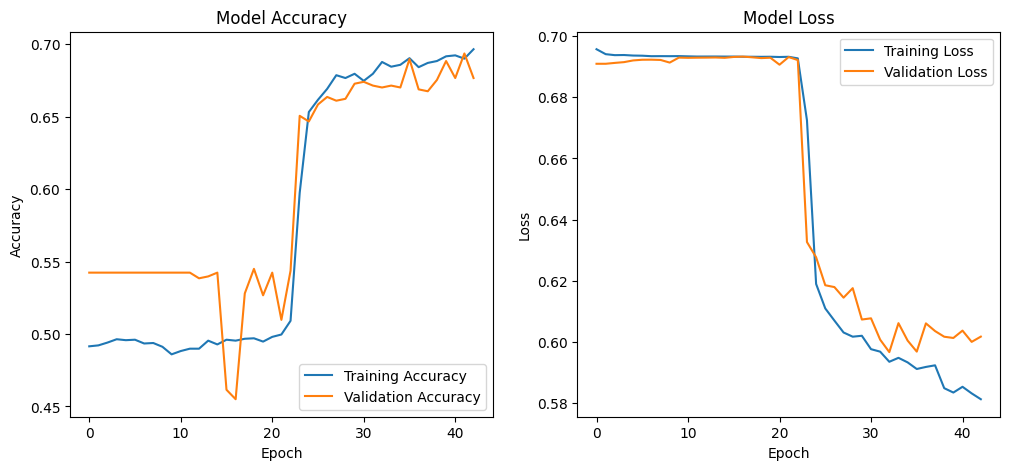

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### Confusion Matrix

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


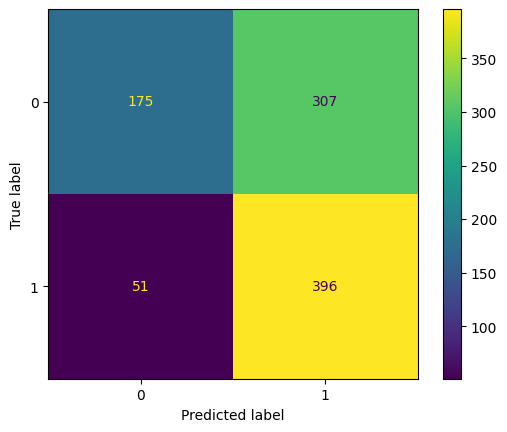

In [36]:
y_pred_probs = model.predict(x_test_new)

y_pred = (y_pred_probs > 0.3).astype(int)  # False Negatives have a higher penalty

cm = confusion_matrix(y_test_new, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### F2_Score

In [37]:
from sklearn.metrics import fbeta_score

f2 = fbeta_score(y_test_new, y_pred, beta=2)
print("F2 Score:", f2)

F2 Score: 0.7948615014050583


### ROC 

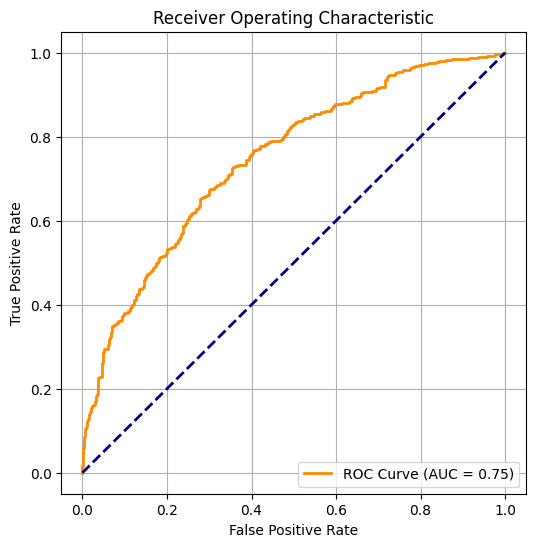

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get FPR, TPR for different thresholds
fpr, tpr, thresholds = roc_curve(y_test_new, y_pred_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [39]:
model.evaluate(x_test_new , y_test_new)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6614 - loss: 0.5992


[0.5956705212593079, 0.6716899871826172]

In [40]:
model.save('RNN-Best.keras')

### Playground